# $\mathrm{BIACET}$ (Biacetyl)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "CH3C(O)C(O)CH3" 
nice_name = "Biacetyl"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

([124.98, 125.03, 125.08, 125.13, 125.18, 125.23, 125.28, 125.33, 125.38, 125.43  …  452.5, 455.0, 457.5, 460.0, 462.5, 465.0, 467.5, 470.0, 472.5, 184.9], [3.97e-17, 3.98e-17, 3.98e-17, 3.98e-17, 3.98e-17, 3.97e-17, 3.96e-17, 3.96e-17, 3.95e-17, 3.94e-17  …  2.81e-20, 1.73e-20, 1.08e-20, 5.41e-21, 3.79e-21, 2.16e-21, 1.08e-21, 1.08e-21, 0.0, 1.46e-18], [323.0, 298.0, 298.0, 298.0, 298.0, 298.0, 298.0, 298.0, 296.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  8, 8, 8, 8, 8, 8, 8, 8, 8, 9], "K", "Organics (carbonyls)", "CH3C(O)C(O)CH3", "nm", "cm^2")

In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

2913


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,350.082,184.9,352.4,494.0,0,Float64
2,σ,3.05439e-20,1.0e-22,2.68e-20,1.46e-18,0,Float64
3,T,297.999,296.0,298.0,298.0,0,Float64
4,source_id,3.54343,2,3.0,9,0,Int64


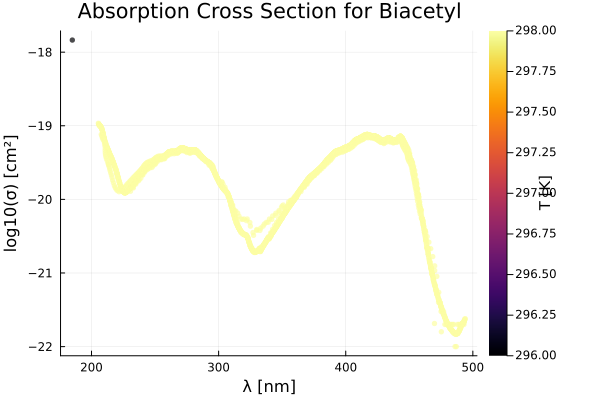

In [8]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)


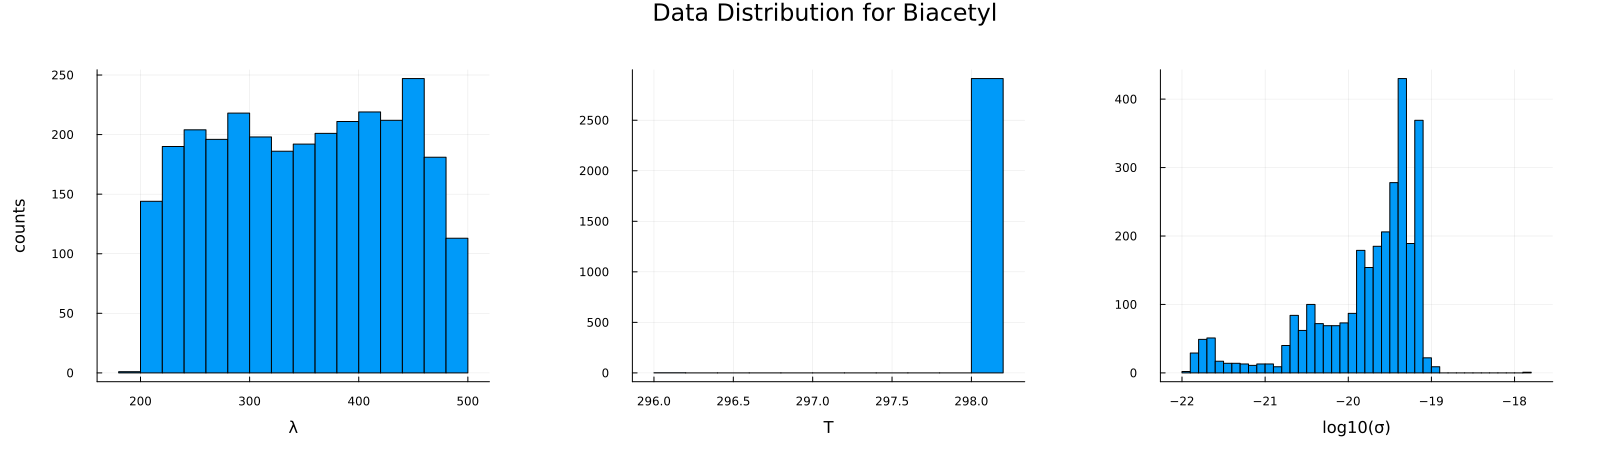

In [9]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [10]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [11]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [12]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,184.9,1.46e-18,296.0
2,205.4,1.08e-19,298.0
3,205.6,1.07e-19,298.0
4,205.8,1.04e-19,298.0
5,206.0,1.03e-19,298.0
6,206.2,1.02e-19,298.0
7,206.4,9.97e-20,298.0
8,206.6,1.0e-19,298.0
9,206.8,9.94e-20,298.0


In [13]:
df_unique = filter_outliers(df_unique, log10.(df_unique.σ))
println(nrow(df_unique))

# df_unique = df_unique[df_unique.T .!= 298.0, :]

1850


In [14]:
λ_idxs = representative_rand_sample(df_unique.λ, 1000, 2000)
# T_idxs = representative_rand_sample(df_unique.λ, 5, 500)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 

# idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs,σ_idxs)))
idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))


df_sampled = df_unique[idxs_res, :]

println(size(df_sampled))

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

(1499, 3)


205.4

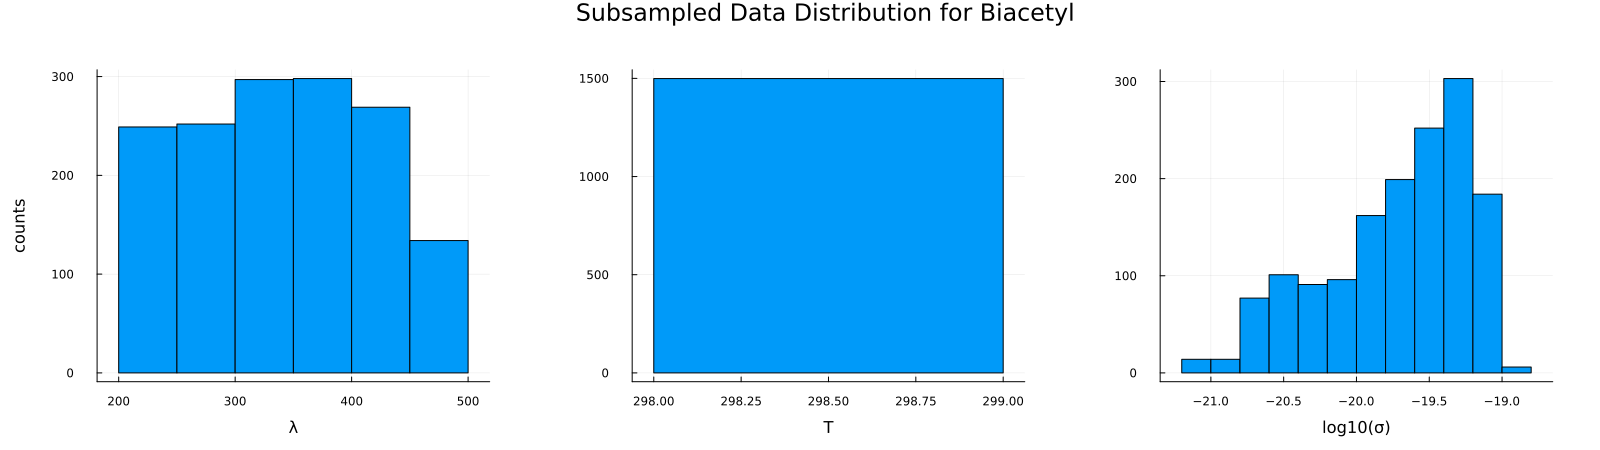

In [15]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

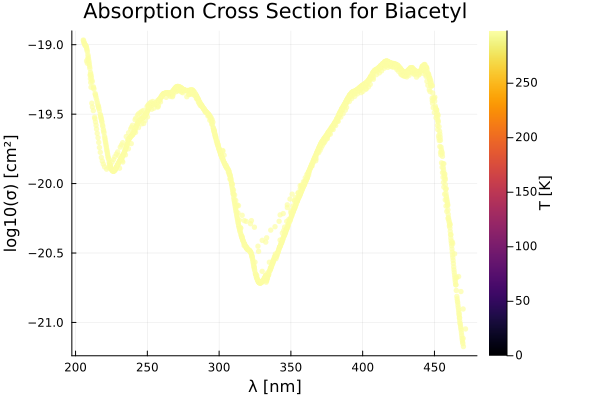

In [16]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [17]:
train_frac = 0.9
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

1349


In [18]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

150-element Vector{Float64}:
 -19.98296666070122
 -19.349692476868064
 -19.51999305704285
 -19.826813731587727
 -19.316052869248487
 -19.279840696594043
 -19.47755576649368
 -19.215382707367123
 -19.404503778174426
 -19.430626090384955
 -19.198596289982646
 -19.89279003035213
 -20.373659632624957
   ⋮
 -19.896196279044045
 -19.694648630553377
 -19.46470587995723
 -19.67366413907125
 -20.25103713874384
 -19.96657624451305
 -19.192464971931148
 -19.58838029403677
 -20.200659450546418
 -19.131355561605176
 -19.826813731587727
 -19.177831920631984

In [19]:
# compute length scales
κ = 10
ℓ_λ = std(Xtrain.λ)/κ
println(ℓ_λ)
# ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
# SNR = 100
σf² = 100*var(ytrain)
println(σf²)

σₙ² = 0.001 # (sqrt(σf²)/SNR)^2

# set up initial values list
#θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ))

function mykernel(θ::NamedTuple)
    # return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ,])
end

7.636864921795161
23.46819552732392


mykernel (generic function with 1 method)

In [20]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(3.1556461220508454, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(2.0329871664600163, exp, 1.4901161193847656e-8)), 
  σ² = 0.001, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [21]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0    -2.098873e+03     3.330200e+02
 * time: 0.01676201820373535
     1    -2.198448e+03     1.583728e+02
 * time: 3.4375112056732178
     2    -2.223617e+03     1.112463e+01
 * time: 4.243022203445435
     3    -2.223906e+03     9.137408e+00
 * time: 4.992653131484985
     4    -2.224504e+03     3.539940e+01
 * time: 6.034367084503174
     5    -2.225937e+03     9.401296e+00
 * time: 6.773038148880005
     6    -2.226140e+03     2.360156e+00
 * time: 7.537603139877319
     7    -2.226150e+03     4.633672e-01
 * time: 8.344197034835815
     8    -2.226150e+03     2.283062e-02
 * time: 8.811829090118408
     9    -2.226150e+03     1.236216e-04
 * time: 9.572585105895996
    10    -2.226150e+03     1.457807e-05
 * time: 10.37447214126587
    11    -2.226150e+03     5.202365e-06
 * time: 10.846001148223877
    12    -2.226150e+03     2.306911e-06
 * time: 11.648186206817627
    13    -2.226150e+03     6.673935e-06
 * time: 12.151610136032104
 

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @988 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @920 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [22]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [3.7276934392330876, 2.5217174337641772, -6.439065840950198],
 minimum = -2226.1500163074174,
 iterations = 186,
 converged = false,)

In [23]:
fp = fitted_params(mach)

(θ_best = [:σf² => 41.583083569110926, :ℓ_λ => 12.449960310090058],
 σ² = 0.0015979135762928924,)

In [24]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


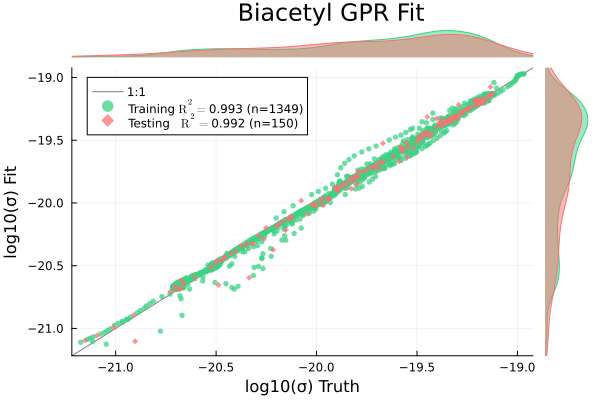

In [25]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


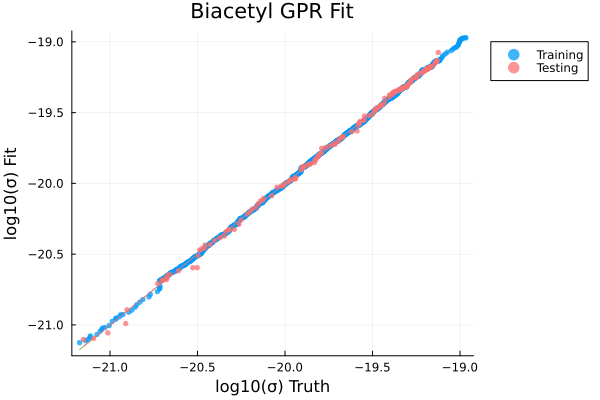

In [26]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


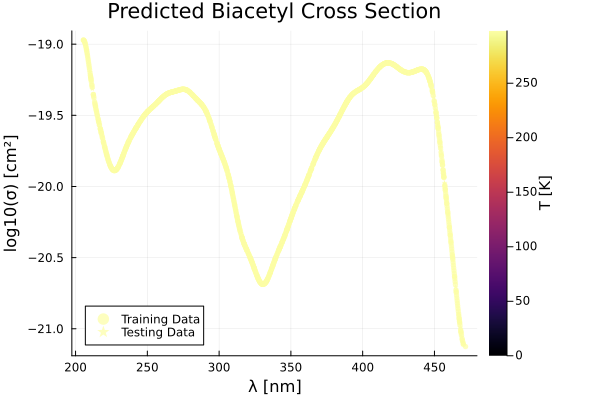

In [27]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

205.4
471.66


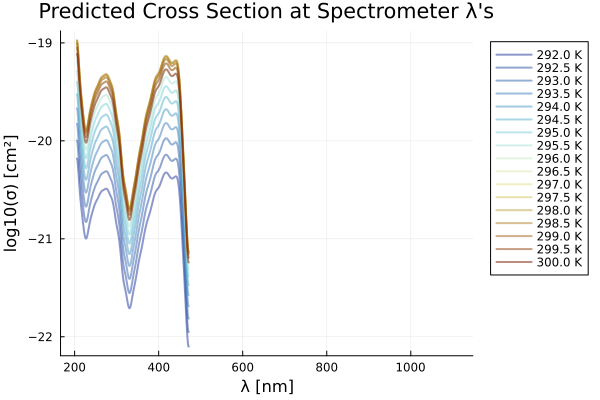

In [28]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

function predict_logσ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = predict_mean(mach, Xout)
    
    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    res[idxs] .= NaN 
    return res
end



p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

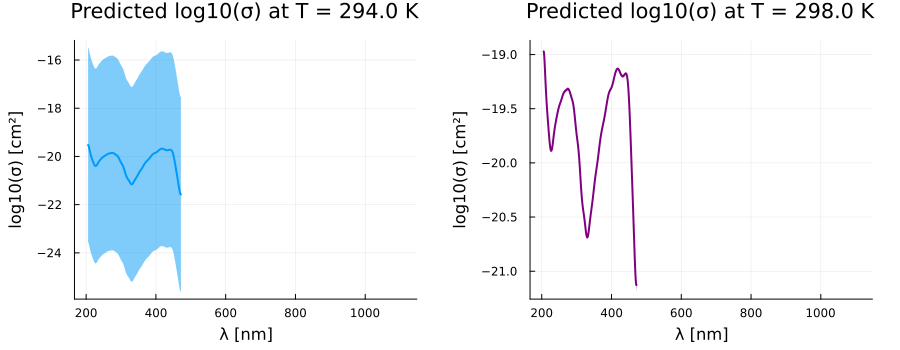

In [29]:
function predict_logσ_wΔ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = MLJ.predict(mach, Xout)

    logσ = mean.(res)
    Δlogσ = std.(res)

    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    logσ[idxs] .= NaN 
    Δlogσ[idxs] .= NaN 
    return logσ, Δlogσ
    #return res
end

Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 